<a href="https://colab.research.google.com/github/TakuroTerui/Gasyori100knock/blob/master/work/Gasyori100knock_Q51_60.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/imori_256x256.png?raw=true')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_128 = io.imread('https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/imori_128x128.png?raw=true')
img_gray_128 = cv2.cvtColor(img_128, cv2.COLOR_RGB2GRAY)
img_noise = io.imread('https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/imori_256x256_noise.png?raw=true')
img_dark = io.imread('https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/imori_256x256_dark.png?raw=true')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/imori_256x256_light.png?raw=true')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)

img_thorino = io.imread('https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/thorino.jpg?raw=true')
img_thorino_gray = cv2.cvtColor(img_thorino, cv2.COLOR_RGB2GRAY)

img_eye = io.imread("https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/imori_256x256_eye.png?raw=true")
img_eye = cv2.cvtColor(img_eye, cv2.COLOR_RGBA2RGB)

img_seg = io.imread("https://github.com/TakuroTerui/Gasyori100knock/blob/master/dataset/images/seg_sample.png?raw=true")

### Q.51. モルフォロジー勾配
大津の二値化を行った後、モルフォロジー勾配を求めよ。

モルフォロジー勾配とはモルフォロジー膨張の画像と収縮の画像の差分をとることで、物体の境界線を抽出する手法である。

ここではモルフォロジー処理のN=1とする。

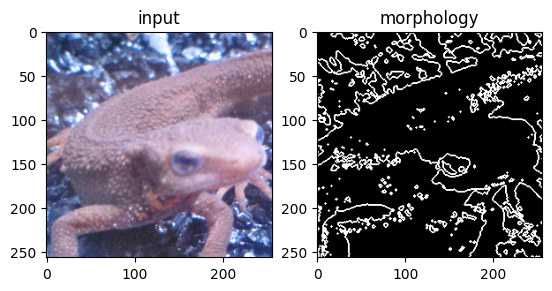

In [3]:
def morphology_erode(img, repeat=1):
    h, w = img.shape
    out = img.copy()

    # kernel
    mf = np.array(((0, 1, 0),
                (1, 0, 1),
                (0, 1, 0)), dtype=int)

    # each erode
    for i in range(repeat):
        tmp = np.pad(out, (1, 1), 'edge')
        # erode
        for y in range(1, h + 1):
            for x in range(1, w + 1):
                if np.sum(mf * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                    out[y-1, x-1] = 0

    return out

def morphology_dilate(img, repeat=1):
    h, w = img.shape

    # kernel
    mf = np.array(((0, 1, 0),
                (1, 0, 1),
                (0, 1, 0)), dtype=int)

    # each dilate time
    out = img.copy()
    for i in range(repeat):
        tmp = np.pad(out, (1, 1), 'edge')
        for y in range(1, h+1):
            for x in range(1, w+1):
                if np.sum(mf * tmp[y-1:y+2, x-1:x+2]) >= 255:
                    out[y-1, x-1] = 255

    return out



_, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Erode image
eroded = morphology_erode(otsu)

# Delate image
dilated = morphology_dilate(otsu)

# Morphology
out = np.abs(eroded - dilated) * 255


plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title("morphology")
plt.imshow(out, cmap="gray")
plt.show()

### Q.52. トップハット変換
大津の二値化を行った後、トップハット変換を行え。

トップハット変換とは元画像からオープニング処理を行った画像を差し引いた画像であり、細い線状のものやノイズなどを抽出できると言われる。

ここでは、大津の二値化画像からオープニング処理画像(N=3)を差し引いて求めよ。

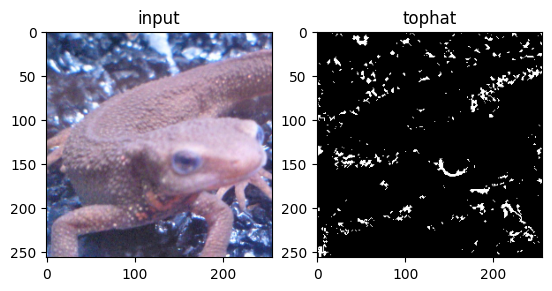

In [4]:
time = 3
out = morphology_dilate(otsu, repeat=time)
out = morphology_erode(out, repeat=time)

out = np.abs(otsu - out) * 255
                
plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title("tophat")
plt.imshow(out, cmap="gray")
plt.show()

### Q.53. ブラックハット変換
大津の二値化を行った後、ブラックハット変換を行え。

ブラックハット変換とはクロージング画像から元画像を差し引いた画像であり、これもトップ変換同様に細い線状やノイズを抽出できると言われる。

ここでは、クロージング処理画像(N=3)から大津の二値化画像を差し引いて求めよ。

＊ここの問題だと効果が分かりにくいので、他の画像があればそのうち訂正します。

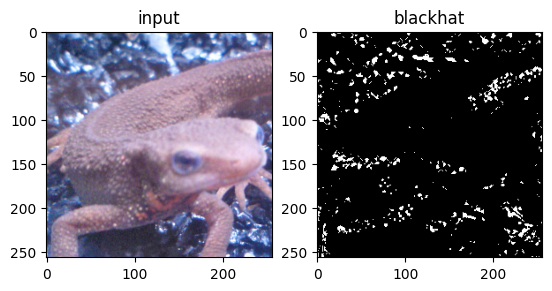

In [5]:
time = 3
out = morphology_erode(otsu, repeat=time)
out = morphology_dilate(out, repeat=time)

out = np.abs(otsu - out) * 255
                
plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title("blackhat")
plt.imshow(out, cmap="gray")
plt.show()

### Q.54. テンプレートマッチング SSD
ここではテンプレートマッチングのSSDを用いて、imori_256x256_eye.png が imori_256x256.png のどこに位置するかを図示せよ。

テンプレートマッチングとは、テンプレート画像と全体画像の一部分で類似度が高い位置を探す手法であり、物体検出などで使われる。今では物体検出はCNNで行われるが、テンプレートマッチングは最も基本処理となる。

アルゴリズムとしては、画像I (H x W)、テンプレート画像T (h x w)とすると、

画像Iにおいて、for ( j = 0, H-h) for ( i = 0, W-w)と1ピクセルずつずらしながら画像Aの一部分I(i:i+w, j:j+h)とテンプレート画像の類似度Sを計算する。 Sが最大もしくは最小の位置がマッチング位置となる。 Sの選び方は主にSSD, SAD(Q.55), NCC(Q.56), ZNCC(Q.57)などがあり、それぞれ最大値をとるか最小値をとるか異なる。

ここではSSD(Sum of Squared Difference)を用いる。 SSDとは画素値の差分の二乗値の和を類似度にする手法であり、Sが最小の位置がマッチング位置となる。

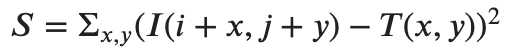

ちなみにテンプレートマッチングのように画像を左上から右に順に見ていくことを走査(ラスタスキャン)やスライディングウィンドウと呼ぶ。このワードは画像処理でよく出る頻出である。

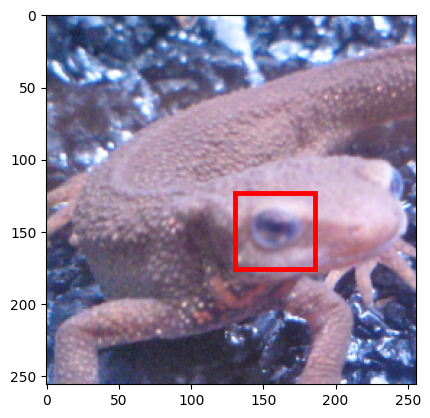

In [6]:
def template_matching_ssd(img, template):
    h, w, c = img.shape
    ht, wt, ct = template.shape

    resx, resy = -1, -1
    v = 255 * h * w * c

    for y in range(h - ht):
        for x in range(w - wt):
            _v = np.sum((img[y : y + ht, x : x + wt] - template) ** 2)

            if _v < v:
                v = _v
                resx, resy = x, y

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.add_patch( plt.Rectangle((resx, resy), wt, ht, fill=False, edgecolor='red', linewidth=3.5) )
    plt.show()

# template matching
template_matching_ssd(img_orig, img_eye)

### Q.55. テンプレートマッチング SAD
ここではテンプレートマッチングのSADを用いて、imori_256x256_eye.png が imori_256x256.png のどこに位置するかを図示せよ。

SAD(Sum of Absolute Difference)とは画素値の差分の絶対値の和を類似度にする手法であり、Sが最小の位置がマッチング位置となる。

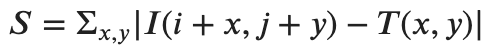

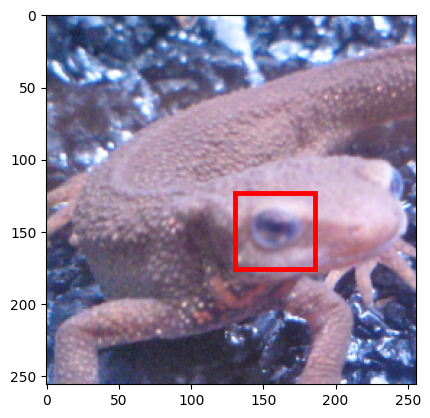

In [7]:
def template_matching_sad(img, template):
    h, w, c = img.shape
    ht, wt, ct = template.shape

    resx, resy = -1, -1
    v = 255 * h * w * c

    for y in range(h - ht):
        for x in range(w - wt):
            _v = np.sum(np.abs(img[y : y + ht, x : x + wt] - template))

            if _v < v:
                v = _v
                resx, resy = x, y

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.add_patch( plt.Rectangle((resx, resy), wt, ht, fill=False, edgecolor='red', linewidth=3.5) )
    plt.show()
    
    
# template matching
template_matching_sad(img_orig, img_eye)

### Q.56. テンプレートマッチング NCC
ここではテンプレートマッチングのNCCを用いて、imori_256x256_eye.png が imori_256x256.png のどこに位置するかを図示せよ。

NCC(Normalized Cross Correlation)とは正規化相互相関を類似度にする手法であり、Sが最大の位置がマッチング位置となる。

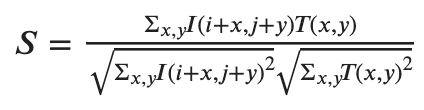

このSは、-1<=S<=1をとる。 NCCは照明変化に強いと言われる。

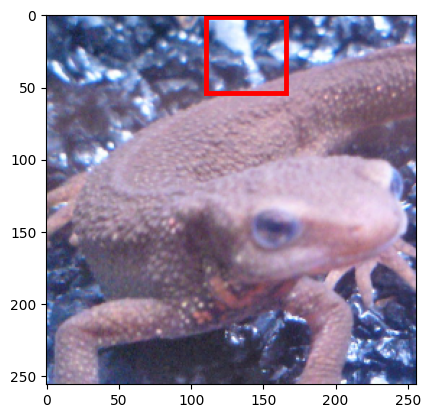

In [8]:
def template_matching_ncc(img, template):
    h, w, c = img.shape
    ht, wt, ct = template.shape

    resx, resy = -1, -1
    v = -1

    for y in range(h - ht):
        for x in range(w - wt):
            _v = np.sum(img[y : y + ht, x : x + wt] * template)
            _v /= (np.sqrt(np.sum(img[y : y + ht, x : x + wt] ** 2)) * np.sqrt(np.sum(template ** 2)))
            if _v > v:
                v = _v
                resx, resy = x, y

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.add_patch( plt.Rectangle((resx, resy), wt, ht, fill=False, edgecolor='red', linewidth=3.5) )
    plt.show()
    
    
# template matching
template_matching_ncc(img_orig, img_eye)

### Q.57. テンプレートマッチング ZNCC
ここではテンプレートマッチングのZNCCを用いて、imori_256x256_eye.png が imori_256x256.png のどこに位置するかを図示せよ。

ZNCC(Zero means Normalized Cross Correlation)とは零平均正規化相互相関を類似度にする手法であり、Sが最大の位置がマッチング位置となる。

画像Iの平均値をmi、画像Tの平均値をmtとすると、Sは次式で計算される。（ただし、平均値はRGB成分ごとに減算する）

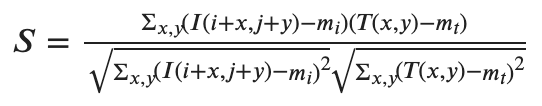

このSは、-1<=S<=1をとる。 ZNCCは平均値を引くことでNCCよりも照明変化に強いと言われる。

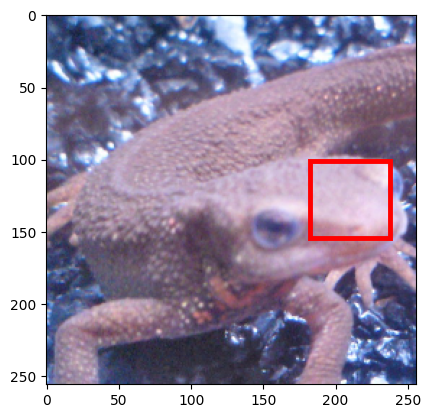

In [9]:
def template_matching_zncc(img, template):
    h, w, c = img.shape
    ht, wt, ct = template.shape
    
    _img = img.copy() - img.mean()
    _template = template.copy() - template.mean()

    resx, resy = -1, -1
    v = -1

    for y in range(h - ht):
        for x in range(w - wt):
            _v = np.sum(_img[y : y + ht, x : x + wt] * template)
            _v /= (np.sqrt(np.sum(_img[y : y + ht, x : x + wt] ** 2)) * np.sqrt(np.sum(_template ** 2)))
            if _v > v:
                v = _v
                resx, resy = x, y

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.add_patch( plt.Rectangle((resx, resy), wt, ht, fill=False, edgecolor='red', linewidth=3.5) )
    plt.show()
    
    
# template matching
template_matching_zncc(img_orig, img_eye)

### Q.58. ラベリング 4近傍
seg.pngをラベリングせよ。

ラベリングとは隣接したピクセルに同じラベルを割り当てる作業である。

つまり、

- 黒　黒　黒　黒
- 黒　白　白　黒
- 黒　白　黒　黒
- 黒　黒　黒　黒

このように隣り合った白ピクセルは同じラベルを割り当てる。

このようにピクセルの塊にラベリングしたものはConnected Componentとも呼ばれる。

ここでは４近傍に注目してラベリングを行う。 また、ここではルックアップテーブルというものを使用する。

ルックアップテーブルとは

|Source|Distination|
| ---- | ---- |
|1|1|
|2|2|
|3|1|

というような表になっており、Source=1に割り当てた画素には最終的にラベル1を割り当てる、Source =3に割り当てた画素には最終的にラベル1を割り当てることを示す表である。

アルゴリズムは

左上からラスタスキャンを行う。 注目画素i(x,y)が黒画素なら何も行わない。白画素なら、上画素i(x,y-1)と左画素i(x-1,y)に注目し、どちらも0だった場合、最後に割り当てたラベル+1を割り当てる。 どちらか一方以上が0でない場合（つまりすでにラベルが割り合っている場合）、上と左に割り当てられたラベルの中で最小の方(0以外)をi(x,y)に割り当てる。ここで、上か左で用いなかったラベルに対応するルックアップテーブルをここで割り当てた番号に変える。 最後、ルックアップテーブルを見て、Sourceに対応する画素に当たる部分をDistinationの値に変換する。 以上により隣接ピクセル同士に同じラベルを割り当てる。 4近傍としているが、ラスタスキャンのため、上画素と左画素の２画素に注目すればいい。

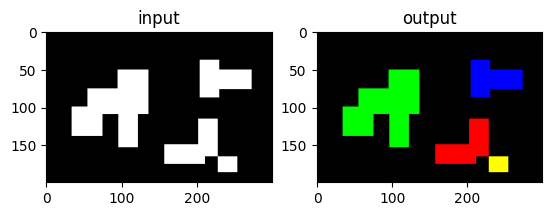

In [10]:
def labeling_4nn(img):
    h, w = img.shape

    label = np.zeros((h, w), dtype=int)
    label[img > 0] = 1

    # look up table
    LUT = [0 for _ in range(h * w)]

    n = 1

    for y in range(h):
        for x in range(w):
            # skip black pixel
            if label[y, x] == 0:
                continue
            
            # get above pixel
            c3 = label[max(y-1,0), x]

            # get left pixel
            c5 = label[y, max(x-1,0)]

            # if not labeled
            if c3 < 2 and c5 < 2:
                # labeling
                n += 1
                label[y, x] = n
            else:
                # replace min label index
                _vs = [c3, c5]
                vs = [a for a in _vs if a > 1]
                v = min(vs)
                label[y, x] = v
                
                minv = v
                for _v in vs:
                    if LUT[_v] != 0:
                        minv = min(minv, LUT[_v])
                for _v in vs:
                    LUT[_v] = minv
                    
    count = 1

    # integrate index of look up table
    for l in range(2, n+1):
        flag = True
        for i in range(n+1):
            if LUT[i] == l:
                if flag:
                    count += 1
                    flag = False
                LUT[i] = count

    # draw color
    COLORS = [[0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 255, 0]]
    out = np.zeros((h, w, 3), dtype=np.uint8)

    for i, lut in enumerate(LUT[2:]):
        out[label == (i+2)] = COLORS[lut-2]

    return out

out = labeling_4nn(img_seg)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_seg, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("output")
plt.imshow(out)
plt.show()

### Q.59. ラベリング 8近傍
ここではQ.58のラベリングを8近傍に変えてラベリングを行え。

8近傍とは、i(x-1,y-1), i(x, y-1), i(x+1,y-1), i(x-1,y)の4画素に注目すればよい。

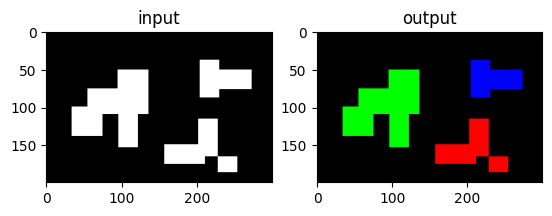

In [11]:
def labeling_8nn(img):
    # get image shape
    h, w = img.shape

    # prepare labeling image
    label = np.zeros((h, w), dtype=int)
    label[img > 0] = 1

    # look up table
    LUT = [0 for _ in range(h * w)]

    n = 1

    for y in range(h):
        for x in range(w):
            if label[y, x] == 0:
                continue
            # get right top pixel
            c2 = label[max(y-1,0), min(x+1, w-1)]
            # get top pixel
            c3 = label[max(y-1,0), x]
            # get left top pixel
            c4 = label[max(y-1,0), max(x-1,0)]
            # get left pixel
            c5 = label[y, max(x-1,0)]

            # if all pixel is non labeled
            if c3 < 2 and c5 < 2 and c2 < 2 and c4 < 2:
                n += 1
                label[y, x] = n
            else:
                # get labeled index
                _vs = [c3, c5, c2, c4]
                vs = [a for a in _vs if a > 1]
                v = min(vs)
                label[y, x] = v

                minv = v
                for _v in vs:
                    if LUT[_v] != 0:
                        minv = min(minv, LUT[_v])
                for _v in vs:
                    LUT[_v] = minv
                    
    count = 1

    # integrate labeled index of look up table
    for l in range(2, n+1):
        flag = True
        for i in range(n+1):
            if LUT[i] == l:
                if flag:
                    count += 1
                    flag = False
                LUT[i] = count

    # draw color
    COLORS = [[0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 255, 0]]
    out = np.zeros((h, w, 3), dtype=np.uint8)

    for i, lut in enumerate(LUT[2:]):
        out[label == (i+2)] = COLORS[lut-2]

    return out

out = labeling_8nn(img_seg)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_seg, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("output")
plt.imshow(out)
plt.show()

### Q.60. アルファブレンド
アルファブレンドにより、imori_256x256.jpgとthorino.jpgを6:4の割合で画像を合成せよ。

アルファブレンドとは透明度（アルファ値）を設定することにより画像の透明度を設定する方法である。 OpenCVでは透明度のパラメータはないが、PILなどのライブラリでは存在する。 ここではその透明度を手動で設定する。

二つの画像を重ね合わせたい時などに、この手法は有効である。

img1とimg2を1:1の割合で重ね合わせたい時は、次式となる。 alphaの値を変えることで重ねる時の重みを変えることができる。

alpha = 0.5

out = img1 * alpha + img2 * (1 - alpha)

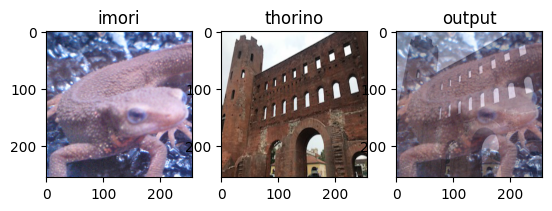

In [12]:
def alpha_blend(img1, img2, alpha):
    out = img1 * alpha + img2 * (1 - alpha)
    out = out.astype(np.uint8)
    return out

thorino_256x256 = cv2.resize(img_thorino, (256, 256))

out = alpha_blend(img_orig, thorino_256x256, 0.6)

plt.subplot(1, 3, 1)
plt.title("imori")
plt.imshow(img_orig, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("thorino")
plt.imshow(thorino_256x256)
plt.subplot(1, 3, 3)
plt.title("output")
plt.imshow(out)
plt.show()